# 1: Сортировка фото кошек и собак с помощью нейронной сети

Подгружаем нужные библиотеки

In [45]:
# Импорт библиотеки TensorFlow под псевдонимом tf
import tensorflow as tf  
# Импорт модуля ImageDataGenerator для аугментации изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
# Импорт класса Model для создания модели нейронной сети
from tensorflow.keras.models import Model  
# Импорт слоев для построения нейронной сети
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
# Импорт предварительно обученной модели MobileNet и функции для предварительной 
# обработки входных данных  
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input  
# Импорт модуля для предварительной обработки изображений
from tensorflow.keras.preprocessing import image  
# Импорт модуля для математических операций
import math  
# Импорт библиотеки Matplotlib для визуализации данных
import matplotlib.pyplot as plt  
# Импорт библиотеки NumPy для работы с массивами
import numpy as np
# Импорт модуля Image из библиотеки Pillow для работы с изображениями  
from PIL import Image


**Скачиваем файлы:** https://disk.yandex.ru/d/OYYCfSzhfRcw8w \
Файлы уже отсортированы по папкам: \
– в папке ${\bf train}$ файлы для обучения нейросети \
– в папке ${\bf test}$ файлы для проверки нейросети \
Внутри этих папок есть папки ${\bf cats}$ и ${\bf dogs}$, где собрано несколько десятков фотографий с кошками и собаками. \
 \
${\bf Ответьте~на~вопрос:~для~чего~нужны~константы,~которые~вводятся~ниже?}$

In [46]:
TRAIN_DATA_DIR = 'C:/AirplanesTanks/train'  # Путь к каталогу с обучающими данными
VALIDATION_DATA_DIR = 'C:/AirplanesTanks/test'  # Путь к каталогу с данными для валидации
TRAIN_SAMPLES = 1000  # Общее количество обучающих примеров
VALIDATION_SAMPLES = 200  # Общее количество примеров для валидации
NUM_CLASSES = 2  # Количество классов (в данном случае два класса: 'самолёты' и 'танки')
IMG_WIDTH, IMG_HEIGHT = 224, 224  # Размеры изображений (ширина и высота)
BATCH_SIZE = 5  # Размер пакета для обучения модели (количество образцов, обрабатываемых моделью за один шаг обучения)


Создаются два генератора данных. Для обучения нейросети недостаточно пары сотен фотографий. \
Поэтому будет использоваться такой приём как ${\bf аргументация}$ (что это?)

In [47]:
train_datagen = ImageDataGenerator(  # Создание генератора данных для обучения
    preprocessing_function=preprocess_input,  # Предварительная обработка изображений (в данном случае с использованием функции preprocess_input)
    rotation_range=20,  # Диапазон вращения изображений (от -20 до 20 градусов)
    width_shift_range=0.2,  # Диапазон сдвига изображений по горизонтали (относительно ширины изображения)
    height_shift_range=0.2,  # Диапазон сдвига изображений по вертикали (относительно высоты изображения)
    zoom_range=0.2  # Диапазон масштабирования изображений (от 0.8 до 1.2)
)

val_datagen = ImageDataGenerator(  # Создание генератора данных для валидации
    preprocessing_function=preprocess_input  # Предварительная обработка изображений (в данном случае с использованием функции preprocess_input)
)


In [48]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,  # Путь к каталогу с обучающими данными
    target_size=(IMG_WIDTH, IMG_HEIGHT),  # Желаемый размер изображений (ширина, высота)
    batch_size=BATCH_SIZE,  # Размер пакета для обучения модели
    shuffle=True,  # Перемешивание данных после каждой эпохи
    seed=12345,  # Задание начального состояния для генератора случайных чисел (для воспроизводимости)
    class_mode='categorical'  # Режим классификации (в данном случае многоклассовая классификация)
)

validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,  # Путь к каталогу с данными для валидации
    target_size=(IMG_WIDTH, IMG_HEIGHT),  # Желаемый размер изображений (ширина, высота)
    batch_size=BATCH_SIZE,  # Размер пакета для валидации модели
    shuffle=False,  # Не перемешивать данные (для сохранения порядка)
    class_mode='categorical'  # Режим классификации (в данном случае многоклассовая классификация)
)


Found 491 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


# Создание модели на основе нейронной сети, которая основана на готовой нейронной сети MobileNet (она называется базовой моделью). 
В базовой модели нужно отключить обучение (для всех слоев устанавливается **trainable = False**). \
Входное изображение поступает на вход базовой модели. \
После базовой модели добавляется несколько своих слоев: \
– слой пулинга **GlobalAveragePooling2D**; \
– полносвязный слой из **16 нейронов Dense**; \
– используется механизм Дропаут (случайное отключение нейронных связей во время обучения); \
– последний слой должен выдавать два значения (вероятности того, что на фото кошка или собака – два класса). \
Таким образом мы решаем задачу двухклассовой классификации.

In [49]:
def model_maker():
    # Создание базовой модели MobileNet без верхнего слоя классификации,
    # указывается форма входных данных (ширина, высота, количество каналов)
    base_model = MobileNet(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    
    # Замораживаем веса всех слоев базовой модели, чтобы они не обучались
    for layer in base_model.layers[:]:
        layer.trainable = False
    
    # Определение входного тензора модели
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    
    # Пропуск данных через базовую модель
    custom_model = base_model(input)
    
    # Глобальное пулингование для уменьшения размерности признаков
    custom_model = GlobalAveragePooling2D()(custom_model)
    
    # Полносвязный слой с 16 нейронами и функцией активации ReLU
    custom_model = Dense(16, activation='relu')(custom_model)
    
    # Слой регуляризации для предотвращения переобучения
    custom_model = Dropout(0.25)(custom_model)
    
    # Выходной слой с NUM_CLASSES нейронами и функцией активации softmax для многоклассовой классификации
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    
    # Создание модели с заданными входом и выходом
    return Model(inputs=input, outputs=predictions)


Компилируем и обучаем модель.

In [50]:
model = model_maker()  # Создание модели нейронной сети с помощью функции model_maker()

model.compile(loss='categorical_crossentropy',  # Функция потерь - категориальная перекрестная энтропия
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Оптимизатор - Adam с коэффициентом скорости обучения 0.001
              metrics=['acc'])  # Метрика для оценки производительности модели - точность классификации

num_steps = math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE)  # Вычисление количества шагов обучения

history = model.fit(train_generator,  # Обучение модели на обучающих данных
                steps_per_epoch=num_steps,  # Количество шагов обучения
                epochs=22,  # Количество эпох обучения
                validation_data=validation_generator,  # Данные для валидации модели
                validation_steps=num_steps)  # Количество шагов валидации

Epoch 1/22
200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - acc: 0.9018 - loss: 0.2120 - val_acc: 1.0000 - val_loss: 0.0092
Epoch 2/22
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - acc: 0.9933 - loss: 0.0287 - val_acc: 1.0000 - val_loss: 0.0103
Epoch 3/22
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - acc: 0.9980 - loss: 0.0121 - val_acc: 1.0000 - val_loss: 0.0017
Epoch 4/22
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - acc: 0.9910 - loss: 0.0254 - val_acc: 1.0000 - val_loss: 0.0142
Epoch 5/22
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - acc: 0.9889 - loss: 0.0371 - val_acc: 1.0000 - val_loss: 0.0049
Epoch 6/22
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - acc: 0.9968 - loss: 0.0088 - val_acc: 1.0000 - val_loss: 0.0023
Epoch 7/22
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - acc: 1.0000 - loss: 0.0067 - val_acc: 1.0000 - val_loss: 0.0014
Epoch 8/22
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - acc: 1.0000 - loss: 0.0013 - val_acc: 1.0000 - val_loss: 8.3487e-04
Epoch 9/22
200/200 ━━━━━━━━━━━━━━━━

Построим график.

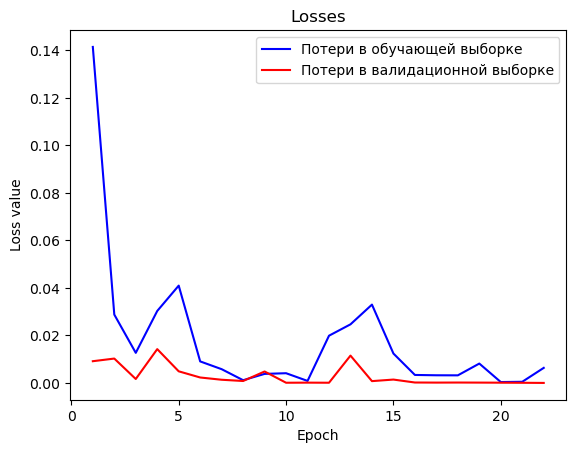

In [51]:
loss_function = history.history['loss']  # Получение значений функции потерь на обучающем наборе данных из истории обучения
val_loss_function = history.history['val_loss']  # Получение значений функции потерь на валидационном наборе данных из истории обучения
epochs = range(1, len(loss_function) + 1)  # Создание списка эпох для оси x

plt.title('Losses')  # Заголовок графика
plt.plot(epochs, loss_function, color='blue', label='Потери в обучающей выборке')  # График функции потерь на обучающем наборе
plt.plot(epochs, val_loss_function, color='red', label='Потери в валидационной выборке')  # График функции потерь на валидационном наборе
plt.xlabel('Epoch')  # Подпись оси x
plt.ylabel('Loss value')  # Подпись оси y
plt.legend()  # Добавление легенды
plt.show()  # Отображение графика




Визуализация функции потерь позволяет оценить эффективность обучения модели: мы стремимся к тому, чтобы функция потерь на обучающем и валидационном наборах данных уменьшалась с каждой эпохой, что свидетельствует о том, что модель обучается эффективно и не переобучается. \
Теперь модель можно использовать и проверить, как она работает.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


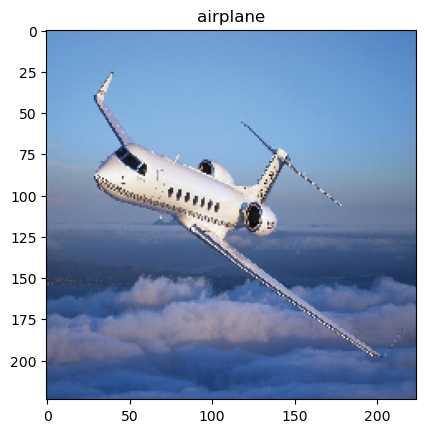

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


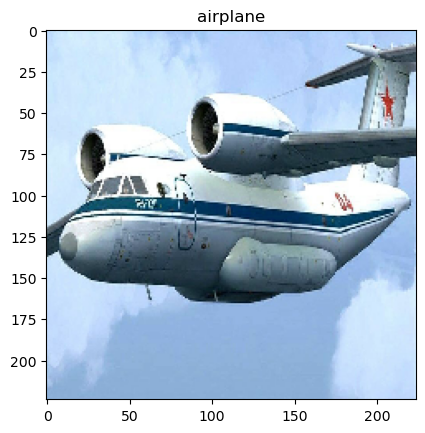

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


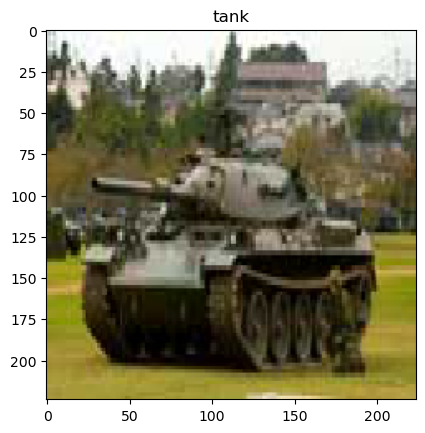

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


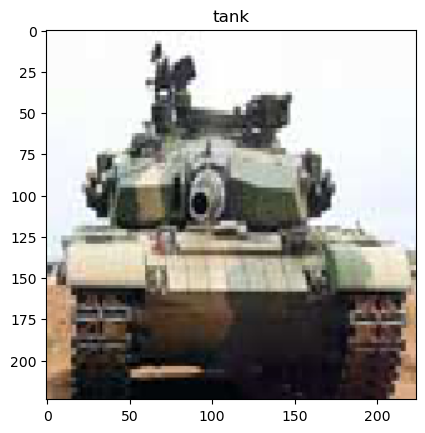

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


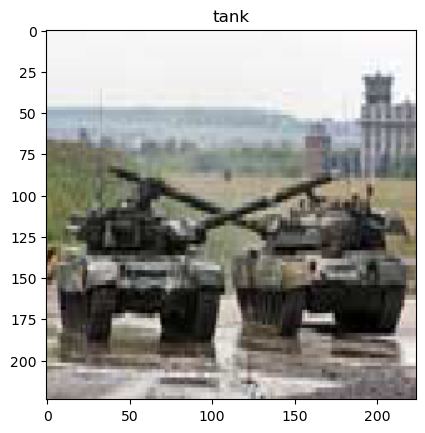

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


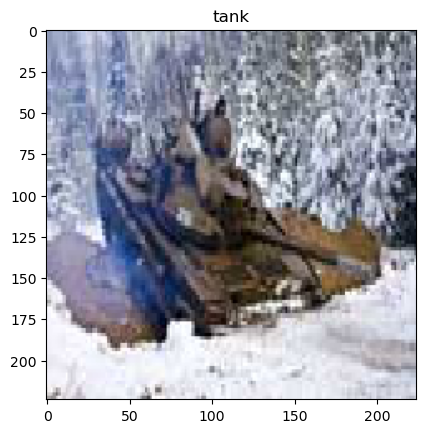

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


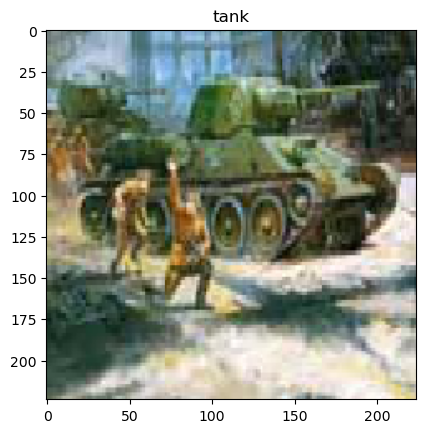

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


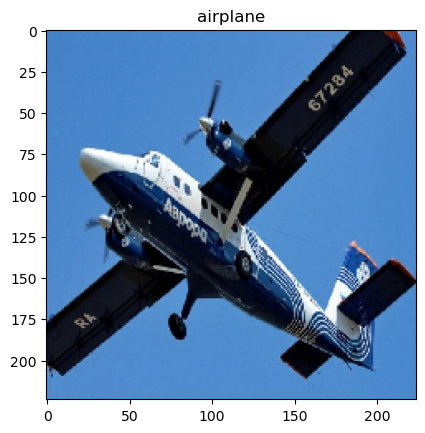

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


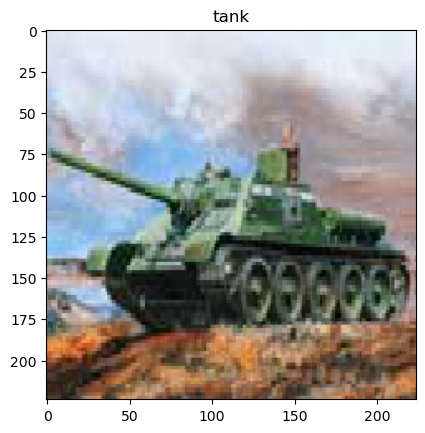

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


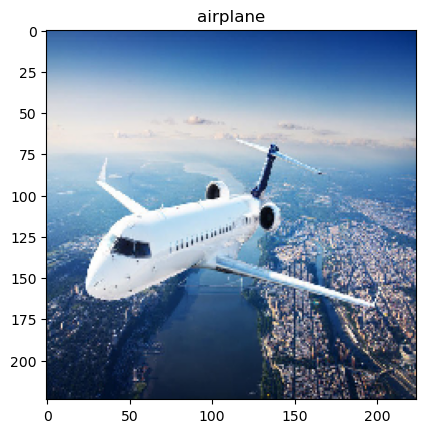

In [52]:
import os  # Импорт модуля os для работы с файловой системой
import random  # Импорт модуля random для работы с случайными числами

categ = ['airplane', 'tank']  # Список категорий: 'airplane' - самолёт 'tank' - танк
files = []  # Пустой список для хранения путей к изображениям

# Перебор всех файлов в каталоге с самолётами и добавление путей в список files
for root, dirs, filenames in os.walk('C:/AirplanesTanks/test/airplanes'):
    for filename in filenames:
        files.append(os.path.join(root, filename))

# Перебор всех файлов в каталоге с танками и добавление путей в список files
for root, dirs, filenames in os.walk('C:/AirplanesTanks/test/tanks'):
    for filename in filenames:
        files.append(os.path.join(root, filename))

# Выбор случайных 10 изображений из списка files и их отображение с предсказанием модели
for f in random.sample(files, 10):
    img_path = f  # Путь к изображению
    img = image.load_img(img_path, target_size=(224,224))  # Загрузка изображения с изменением размера до 224x224 пикселя
    img_array = image.img_to_array(img)  # Преобразование изображения в массив numpy

    expanded_img_array = np.expand_dims(img_array, axis=0)  # Расширение массива изображения
    preprocessed_img = preprocess_input(expanded_img_array)  # Предварительная обработка изображения
    prediction = model.predict(preprocessed_img)  # Получение предсказания от модели
    
    plt.title(categ[np.argmax(prediction)])  # Установка заголовка графика в соответствии с предсказанием модели
    plt.imshow(img)  # Отображение изображения
    plt.show()  # Показ графика
